In [23]:
import os


def parse_annotation(annotation_file_path):
    with open(annotation_file_path, "rt") as file:
        lines = [line.replace("\n", "") for line in file.readlines()]
        image_label = {line.split(" ")[0]: line.split(" ")[1] for line in lines}
    return image_label


TRAINVAL_ANNOTATION_TXT = os.path.join(
    "..", "dataset", "pet", "annotations", "trainval.txt"
)
trainval_label = parse_annotation(TRAINVAL_ANNOTATION_TXT)
trainval_label


{'Abyssinian_100': '1',
 'Abyssinian_101': '1',
 'Abyssinian_102': '1',
 'Abyssinian_103': '1',
 'Abyssinian_104': '1',
 'Abyssinian_105': '1',
 'Abyssinian_106': '1',
 'Abyssinian_107': '1',
 'Abyssinian_108': '1',
 'Abyssinian_109': '1',
 'Abyssinian_10': '1',
 'Abyssinian_110': '1',
 'Abyssinian_111': '1',
 'Abyssinian_112': '1',
 'Abyssinian_113': '1',
 'Abyssinian_114': '1',
 'Abyssinian_115': '1',
 'Abyssinian_116': '1',
 'Abyssinian_117': '1',
 'Abyssinian_118': '1',
 'Abyssinian_119': '1',
 'Abyssinian_11': '1',
 'Abyssinian_120': '1',
 'Abyssinian_121': '1',
 'Abyssinian_122': '1',
 'Abyssinian_123': '1',
 'Abyssinian_124': '1',
 'Abyssinian_125': '1',
 'Abyssinian_126': '1',
 'Abyssinian_127': '1',
 'Abyssinian_128': '1',
 'Abyssinian_129': '1',
 'Abyssinian_12': '1',
 'Abyssinian_130': '1',
 'Abyssinian_131': '1',
 'Abyssinian_132': '1',
 'Abyssinian_133': '1',
 'Abyssinian_134': '1',
 'Abyssinian_135': '1',
 'Abyssinian_136': '1',
 'Abyssinian_137': '1',
 'Abyssinian_138': 

data.shape (200, 200, 3)
label.shape (200, 200)
1    23524
0    10622
2     5854
dtype: int64


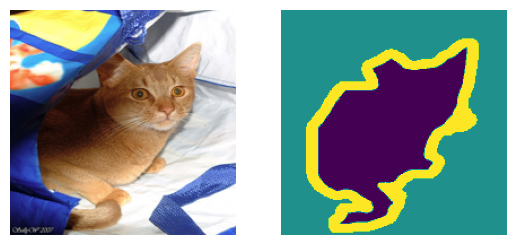

In [148]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np


ANNOTATION_DIR = os.path.join("..", "dataset", "pet", "annotations", "trimaps")
TRAIN_DIR = os.path.join("..", "dataset", "pet", "images")
ANNOTATION_EXTENSION = ".png"
TRAIN_EXTENSION = ".jpg"
IMAGE_SIZE = (200, 200)


def image_dataset_generator(filename_to_label: dict):
    return (
        (
            np.asarray(
                Image.open(
                    os.path.join(TRAIN_DIR, filename + TRAIN_EXTENSION)
                ).resize(IMAGE_SIZE).convert("RGB")
            ),
            np.asarray(
                Image.open(
                    os.path.join(ANNOTATION_DIR, filename + ANNOTATION_EXTENSION)
                ).resize(IMAGE_SIZE)
            )
            - 1,
        )
        for filename, label in filename_to_label.items()
    )


import pandas as pd


for data, label in image_dataset_generator(trainval_label):
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(data)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(label)
    print("data.shape", data.shape)
    print("label.shape", label.shape)
    print(pd.Series(label.flatten()).value_counts())
    break


In [131]:
import tensorflow as tf


trainval_dataset = tf.data.Dataset.from_generator(
    lambda: image_dataset_generator(trainval_label),
    output_signature=(
        tf.TensorSpec(shape=(*IMAGE_SIZE, 3)),
        tf.TensorSpec(shape=IMAGE_SIZE, dtype=tf.int64),
    ),
)
list(trainval_dataset.take(1))

[(<tf.Tensor: shape=(200, 200, 3), dtype=float32, numpy=
  array([[[ 36.,  19.,  11.],
          [ 37.,  20.,  12.],
          [ 36.,  19.,  11.],
          ...,
          [249., 249., 253.],
          [247., 247., 252.],
          [249., 248., 253.]],
  
         [[ 36.,  19.,  11.],
          [ 37.,  19.,  11.],
          [ 36.,  20.,  11.],
          ...,
          [253., 253., 254.],
          [251., 251., 253.],
          [251., 250., 253.]],
  
         [[ 37.,  18.,  11.],
          [ 38.,  19.,  12.],
          [ 38.,  21.,  13.],
          ...,
          [254., 254., 254.],
          [254., 254., 254.],
          [254., 254., 254.]],
  
         ...,
  
         [[  6.,   8.,  27.],
          [  6.,   9.,  27.],
          [  3.,   4.,  21.],
          ...,
          [ 57., 102., 223.],
          [ 53.,  85., 221.],
          [ 59.,  86., 216.]],
  
         [[  3.,   5.,  22.],
          [  4.,   6.,  23.],
          [  4.,   7.,  22.],
          ...,
          [ 64., 110., 23

In [149]:
def get_model(img_size: tuple, num_classes: int):
    input_tensor = tf.keras.Input((*img_size, 3))
    # Preprocessing stage
    x = tf.keras.layers.Rescaling(1./255)(input_tensor)
    # Encoding stage
    x = tf.keras.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    # Decoding stage
    x = tf.keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(
        256, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(
        128, 3, strides=2, activation="relu", padding="same"
    )(x)
    x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(
        64, 3, strides=2, activation="relu", padding="same"
    )(x)
    # Segmenting stage
    output_tensor = tf.keras.layers.Conv2D(
        num_classes, 3, activation="softmax", padding="same"
    )(x)
    return tf.keras.Model(inputs=[input_tensor], outputs=[output_tensor])


model = get_model(IMAGE_SIZE, 3)
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 200, 200, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_57 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_58 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_59 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_60 (Conv2D)          (None, 25, 25, 256)       2951

In [150]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
)



In [151]:
for data, label in trainval_dataset.repeat(64).batch(32):
    print(data.shape)
    print(label.shape)
    break

(32, 200, 200, 3)
(32, 200, 200)


In [152]:
ready_dataset = trainval_dataset.shuffle(5000).batch(32)
history = model.fit(ready_dataset, epochs=10)

Epoch 1/10


2022-10-20 19:57:44.747403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1060 of 5000
2022-10-20 19:57:54.746469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2051 of 5000
2022-10-20 19:58:04.744316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2996 of 5000
2022-10-20 19:58:14.741659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3676 of 5000
2022-10-20 19:58:14.786181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 76s 295ms/step - loss: 11.4455
Epoch 2/10


2022-10-20 19:58:59.115178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1261 of 5000
2022-10-20 19:59:09.106449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2598 of 5000
2022-10-20 19:59:18.758345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 63s 287ms/step - loss: 0.8734
Epoch 3/10


2022-10-20 20:00:02.153322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1411 of 5000
2022-10-20 20:00:12.151449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2804 of 5000
2022-10-20 20:00:18.916209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 60s 286ms/step - loss: 0.8265
Epoch 4/10


2022-10-20 20:01:01.969639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1436 of 5000
2022-10-20 20:01:11.966466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2801 of 5000
2022-10-20 20:01:17.925444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 59s 287ms/step - loss: 0.7786
Epoch 5/10


2022-10-20 20:02:01.210388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1403 of 5000
2022-10-20 20:02:11.212457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2792 of 5000
2022-10-20 20:02:17.790682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 60s 286ms/step - loss: 0.7558
Epoch 6/10


2022-10-20 20:03:00.879957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1426 of 5000
2022-10-20 20:03:10.878865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2790 of 5000
2022-10-20 20:03:16.949839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 59s 287ms/step - loss: 0.6872
Epoch 7/10


2022-10-20 20:04:00.167735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1389 of 5000
2022-10-20 20:04:10.166262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2791 of 5000
2022-10-20 20:04:16.375300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 59s 286ms/step - loss: 0.6612
Epoch 8/10


2022-10-20 20:04:59.460063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1416 of 5000
2022-10-20 20:05:09.459362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2798 of 5000
2022-10-20 20:05:15.414351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 59s 287ms/step - loss: 0.6195
Epoch 9/10


2022-10-20 20:05:58.746429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1468 of 5000
2022-10-20 20:06:08.751814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2747 of 5000
2022-10-20 20:06:18.750458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3663 of 5000
2022-10-20 20:06:18.916803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 63s 287ms/step - loss: 0.5873
Epoch 10/10


2022-10-20 20:07:02.199411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1419 of 5000
2022-10-20 20:07:12.199954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2801 of 5000
2022-10-20 20:07:18.198397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


115/115 [==============================] - 59s 287ms/step - loss: 0.5733


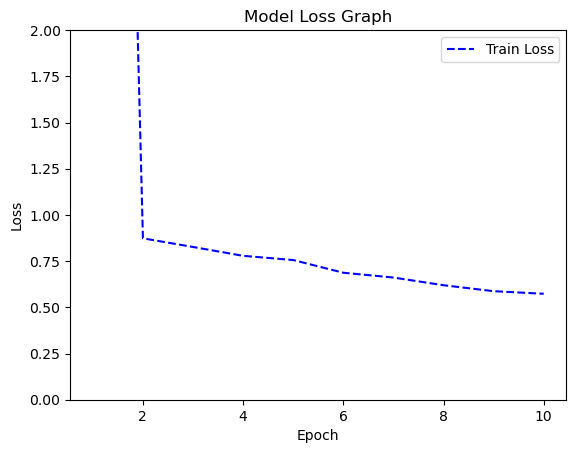

In [163]:
x_range = range(1, len(history.history["loss"]) + 1)
plt.plot(x_range, history.history["loss"], "b--", label="Train Loss")
plt.ylim((0, 2))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss Graph")
plt.legend()